In [1]:
import os
import glob
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.transparent'] = True
matplotlib.rcParams['path.simplify'] = False  # keep exact vectors

In [2]:

# --- Step 1: Load all .tsv files from folder ---
data_dir = "chip_atlas_data"
tsv_files = glob.glob(os.path.join(data_dir, "*.tsv"))

all_data = []
for file in tsv_files:
    tf_name = os.path.basename(file).split(".")[0]
    df = pd.read_csv(file, sep="\t", skiprows=1)
    df = df.rename(columns={df.columns[0]: "Target_gene"})
    df_long = df.melt(id_vars="Target_gene", var_name="Sample", value_name="Binding_score")
    df_long["TF"] = tf_name
    all_data.append(df_long)

all_data = pd.concat(all_data, ignore_index=True)


# --- Step 2: Filter high-confidence interactions ---
filtered = all_data[all_data["Binding_score"] > 900]

In [3]:

# --- Step 2: Filter high-confidence interactions ---
filtered = all_data[all_data["Binding_score"] > 900]

In [4]:

# --- Step 3: Create edge list ---
edge_df = (
    filtered.groupby(["TF", "Target_gene"])["Binding_score"]
    .mean()
    .reset_index()
    .rename(columns={"Binding_score": "Avg_score"})
)

/quobyte/lasallegrp/Ensi/conda_environments/allcools/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


<Figure size 1000x1200 with 0 Axes>

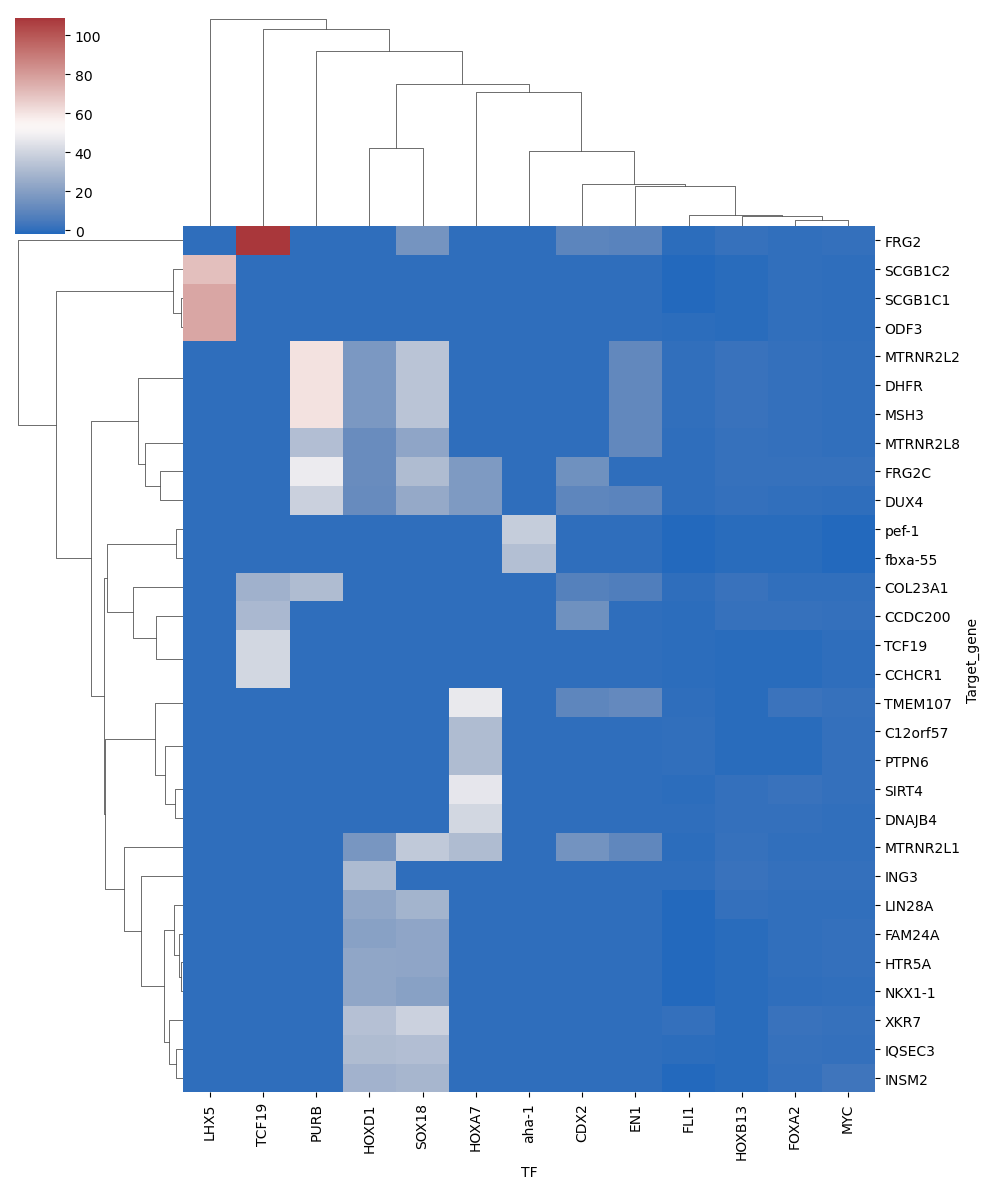

In [7]:


# --- Step 5: Create TF–Target matrix ---
matrix = edge_df.pivot(index="Target_gene", columns="TF", values="Avg_score").fillna(0)

# --- Step 6: Clustering and heatmap ---
scaler = StandardScaler()
matrix_scaled = pd.DataFrame(scaler.fit_transform(matrix), index=matrix.index, columns=matrix.columns)

# Compute linkage for dendrogram
cluster_model = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")
clusters = cluster_model.fit_predict(matrix_scaled)

matrix_scaled["Cluster"] = clusters
top_genes = matrix_scaled.var(axis=1).sort_values(ascending=False).head(30).index

# Heatmap
plt.figure(figsize=(10, 12))
sns.clustermap(matrix_scaled.loc[top_genes].drop(columns="Cluster"), cmap="vlag", figsize=(10, 12))
plt.savefig("TF_Target_Heatmap.png", dpi=300)
plt.show()

/tmp/ipykernel_369069/3123844080.py:119: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


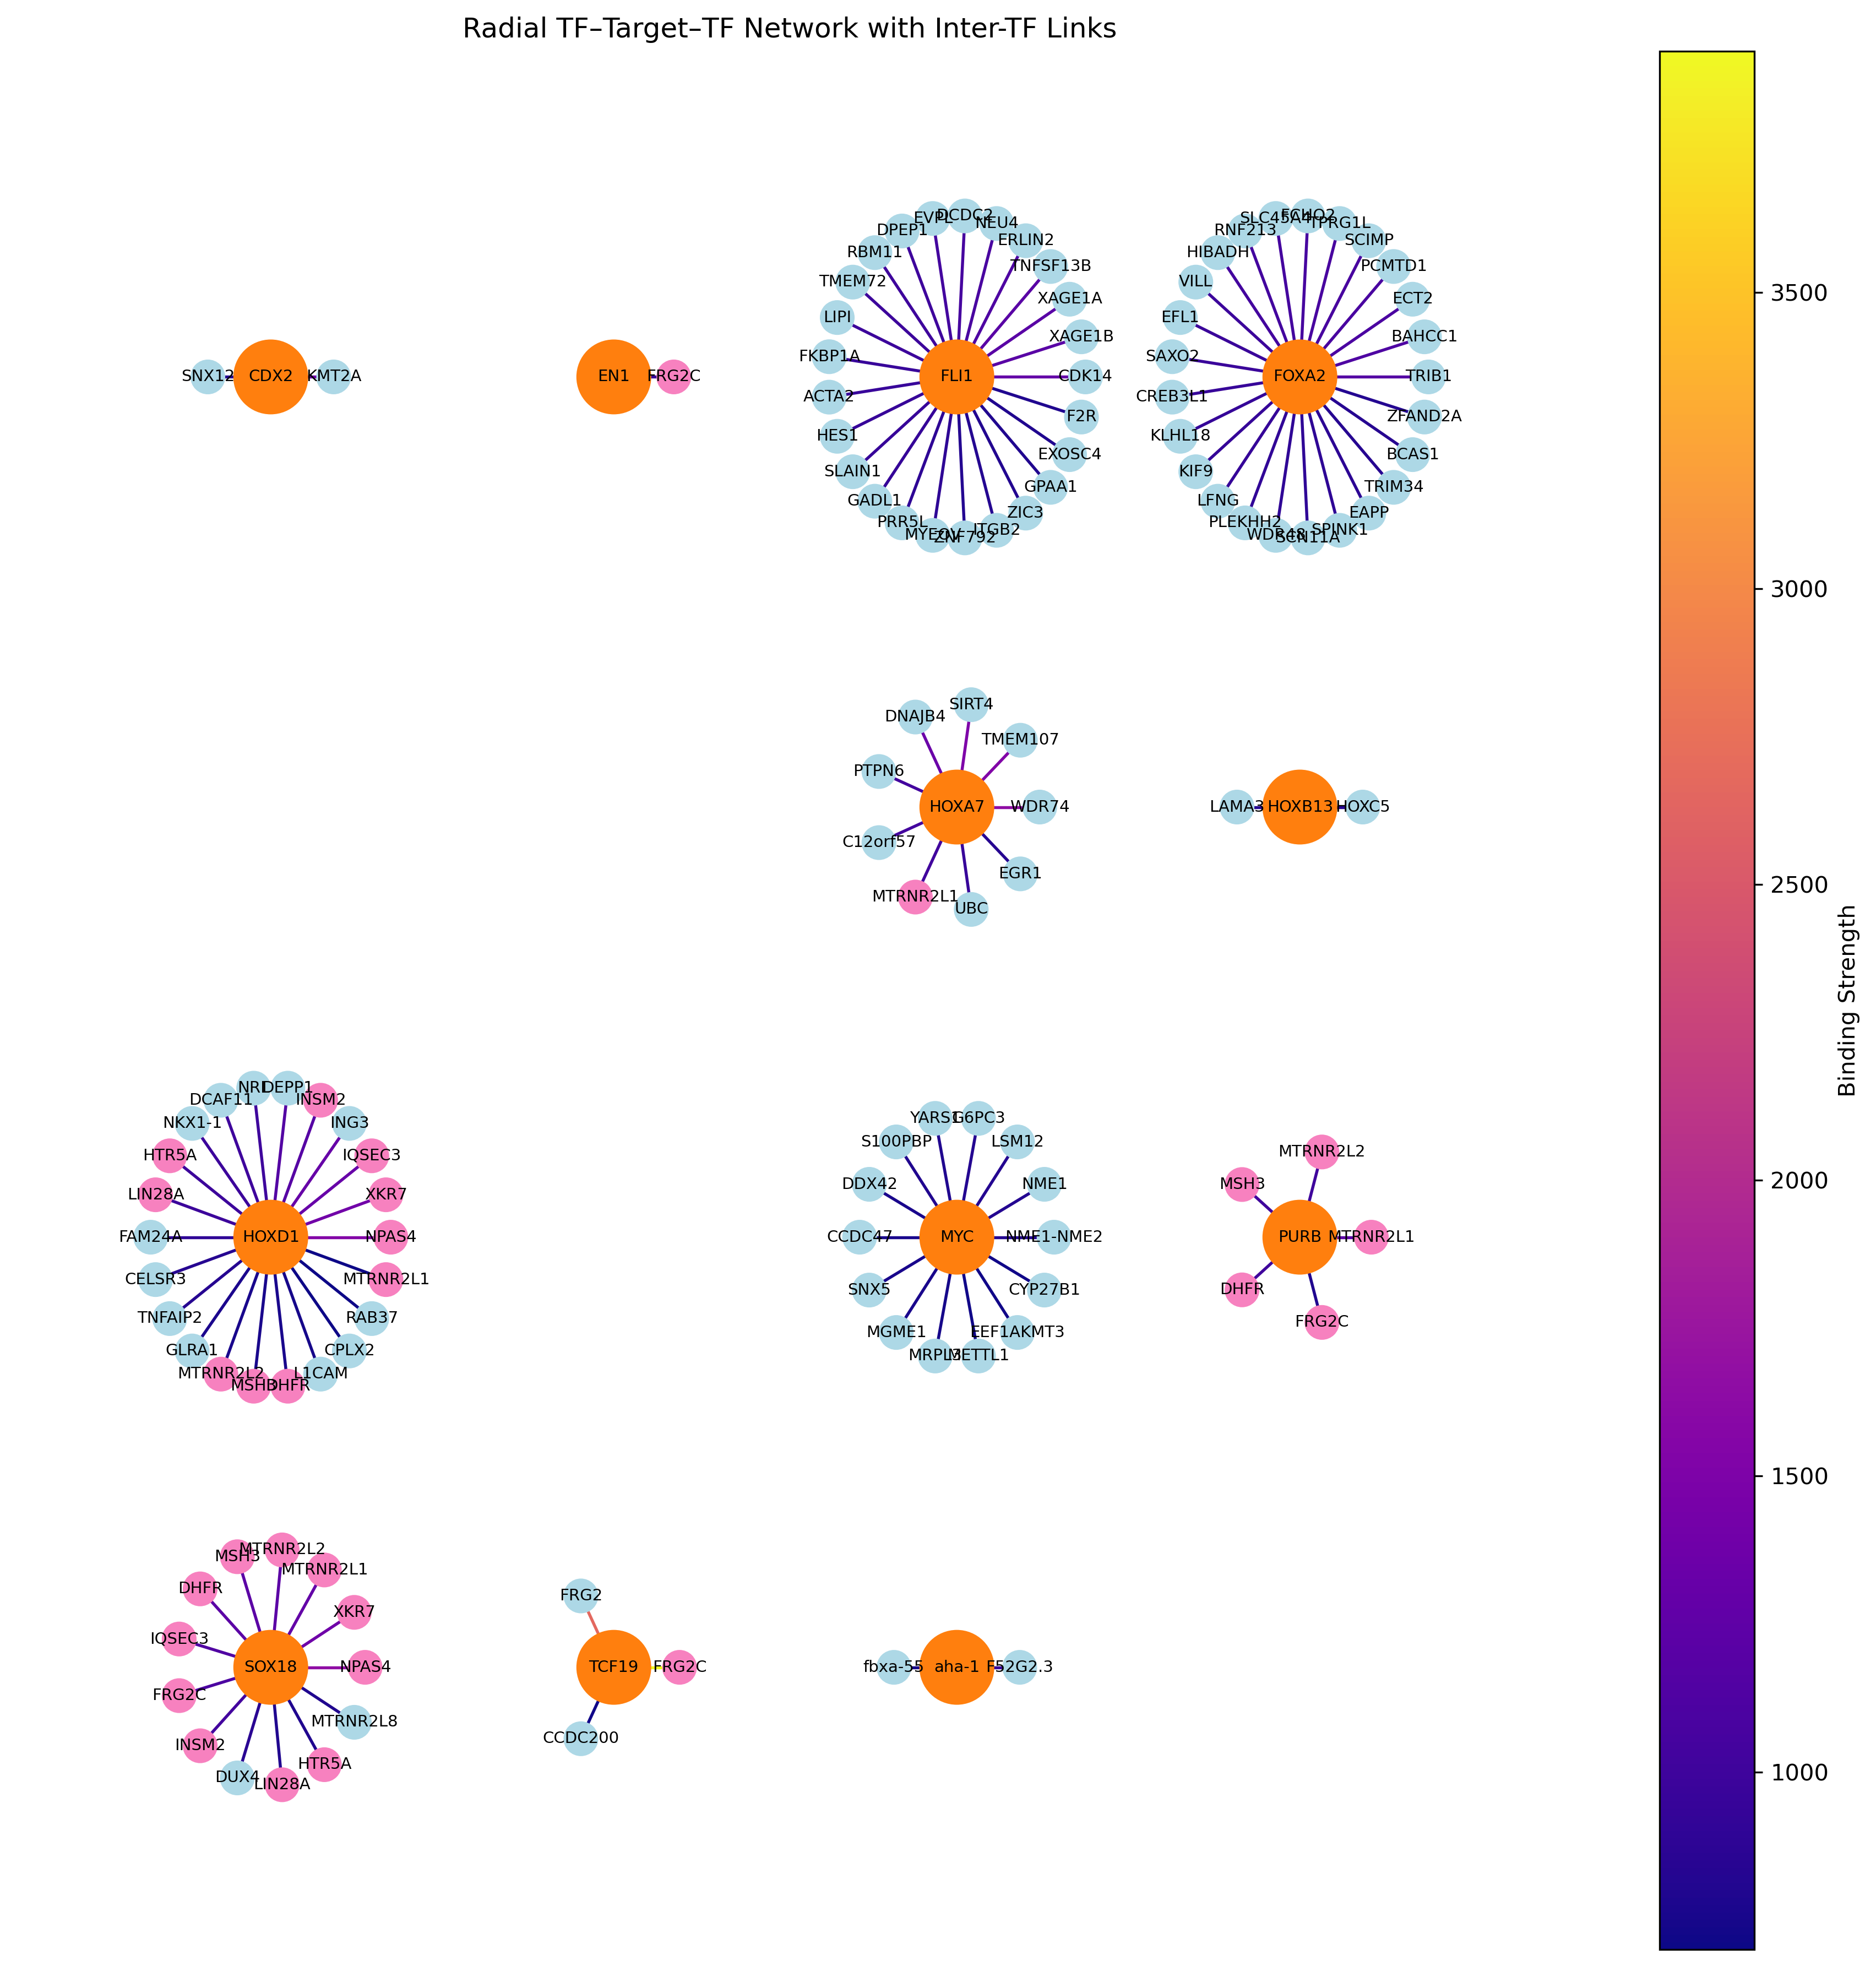

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# Setup
input_dir = "chip_atlas_data"
output_dir = "network_plots"
os.makedirs(output_dir, exist_ok=True)

max_targets = 25
min_strength = 700
cluster_spacing = 6

# Load list of all TFs from file names
tf_files = glob.glob(f"{input_dir}/*.tsv")
tf_list = [os.path.basename(f).split(".")[0] for f in tf_files]

# Initialize graph and layout dict
G = nx.DiGraph()
pos = {}

# Loop through each TF file
for idx, filepath in enumerate(tf_files):
    tf_name = os.path.basename(filepath).split(".")[0]
    df = pd.read_csv(filepath, sep="\t")

    avg_col = [col for col in df.columns if f"{tf_name}|Average" in col]
    if not avg_col:
        continue
    avg_col = avg_col[0]

    df = df[df[avg_col] >= min_strength].sort_values(avg_col, ascending=False).head(max_targets)
    if df.empty:
        continue

    # Add the TF node
    G.add_node(tf_name, type="TF")
    cx = (idx % 4) * cluster_spacing
    cy = -(idx // 4) * cluster_spacing
    pos[tf_name] = np.array([cx, cy])

    tf_targets = []
    shared_counts = {} if idx == 0 else shared_counts  # Only define once

    # Track how many TFs regulate each target gene
    for gene in df["Target_genes"]:
        shared_counts[gene] = shared_counts.get(gene, 0) + 1


    for j, row in df.iterrows():
        target_gene = row["Target_genes"]
        weight = row[avg_col]

        if target_gene in tf_list:
            # TF-to-TF connection
            G.add_edge(tf_name, target_gene, weight=weight)

            if not G.has_node(target_gene):
                G.add_node(target_gene, type="TF")
            if target_gene not in pos:
                # place near source TF
                angle = np.random.rand() * 2 * np.pi
                r_pos = 3
                tx = cx + r_pos * np.cos(angle)
                ty = cy + r_pos * np.sin(angle)
                pos[target_gene] = np.array([tx, ty])
        else:
            # TF-to-target
            target_node = f"{target_gene}__{tf_name}"
            G.add_node(target_node, type="target", gene=target_gene)
            G.add_edge(tf_name, target_node, weight=weight)
            tf_targets.append(target_node)

    # Layout radial targets for this TF
    radial_r = 1.0 + 0.05 * len(tf_targets)  # Dynamic spacing based on number of targets
    for k, tgt in enumerate(tf_targets):
        theta = 2 * np.pi * k / len(tf_targets)
        tx = cx + radial_r * np.cos(theta)
        ty = cy + radial_r * np.sin(theta)
        pos[tgt] = np.array([tx, ty])

# Plot
plt.figure(figsize=(12, 12))

# 🔵 Make TFs orange, targets light blue
#node_colors = ['#ff7f0e' if G.nodes[n]['type'] == 'TF' else '#add8e6' for n in G.nodes]
node_colors = []
for n in G.nodes:
    if G.nodes[n]['type'] == 'TF':
        node_colors.append('#ff7f0e')  # TF = orange
    else:
        gene_name = G.nodes[n]['gene']
        if shared_counts.get(gene_name, 0) > 1:
            node_colors.append('#f781bf')  # shared = pink
        else:
            node_colors.append('#add8e6')  # unique = light blue

node_sizes = [1000 if G.nodes[n]['type'] == 'TF' else 200 for n in G.nodes]
nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=node_sizes)

# Edges with color scaling
edges = G.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges]
min_w, max_w = min(weights), max(weights)
norm_weights = [(w - min_w) / (max_w - min_w + 1e-6) for w in weights]
edge_colors = plt.cm.plasma(norm_weights)
nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, arrows=False, width=1.3)

# Labels
labels = {n: n if G.nodes[n]['type'] == 'TF' else G.nodes[n]['gene'] for n in G.nodes}
nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=7)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min_w, vmax=max_w))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label("Binding Strength")

plt.title("Radial TF–Target–TF Network with Inter-TF Links")
plt.axis('off')
plt.tight_layout()
plt.savefig(f"{output_dir}/tf_network_with_TF_edges.png", dpi=300)
plt.show()


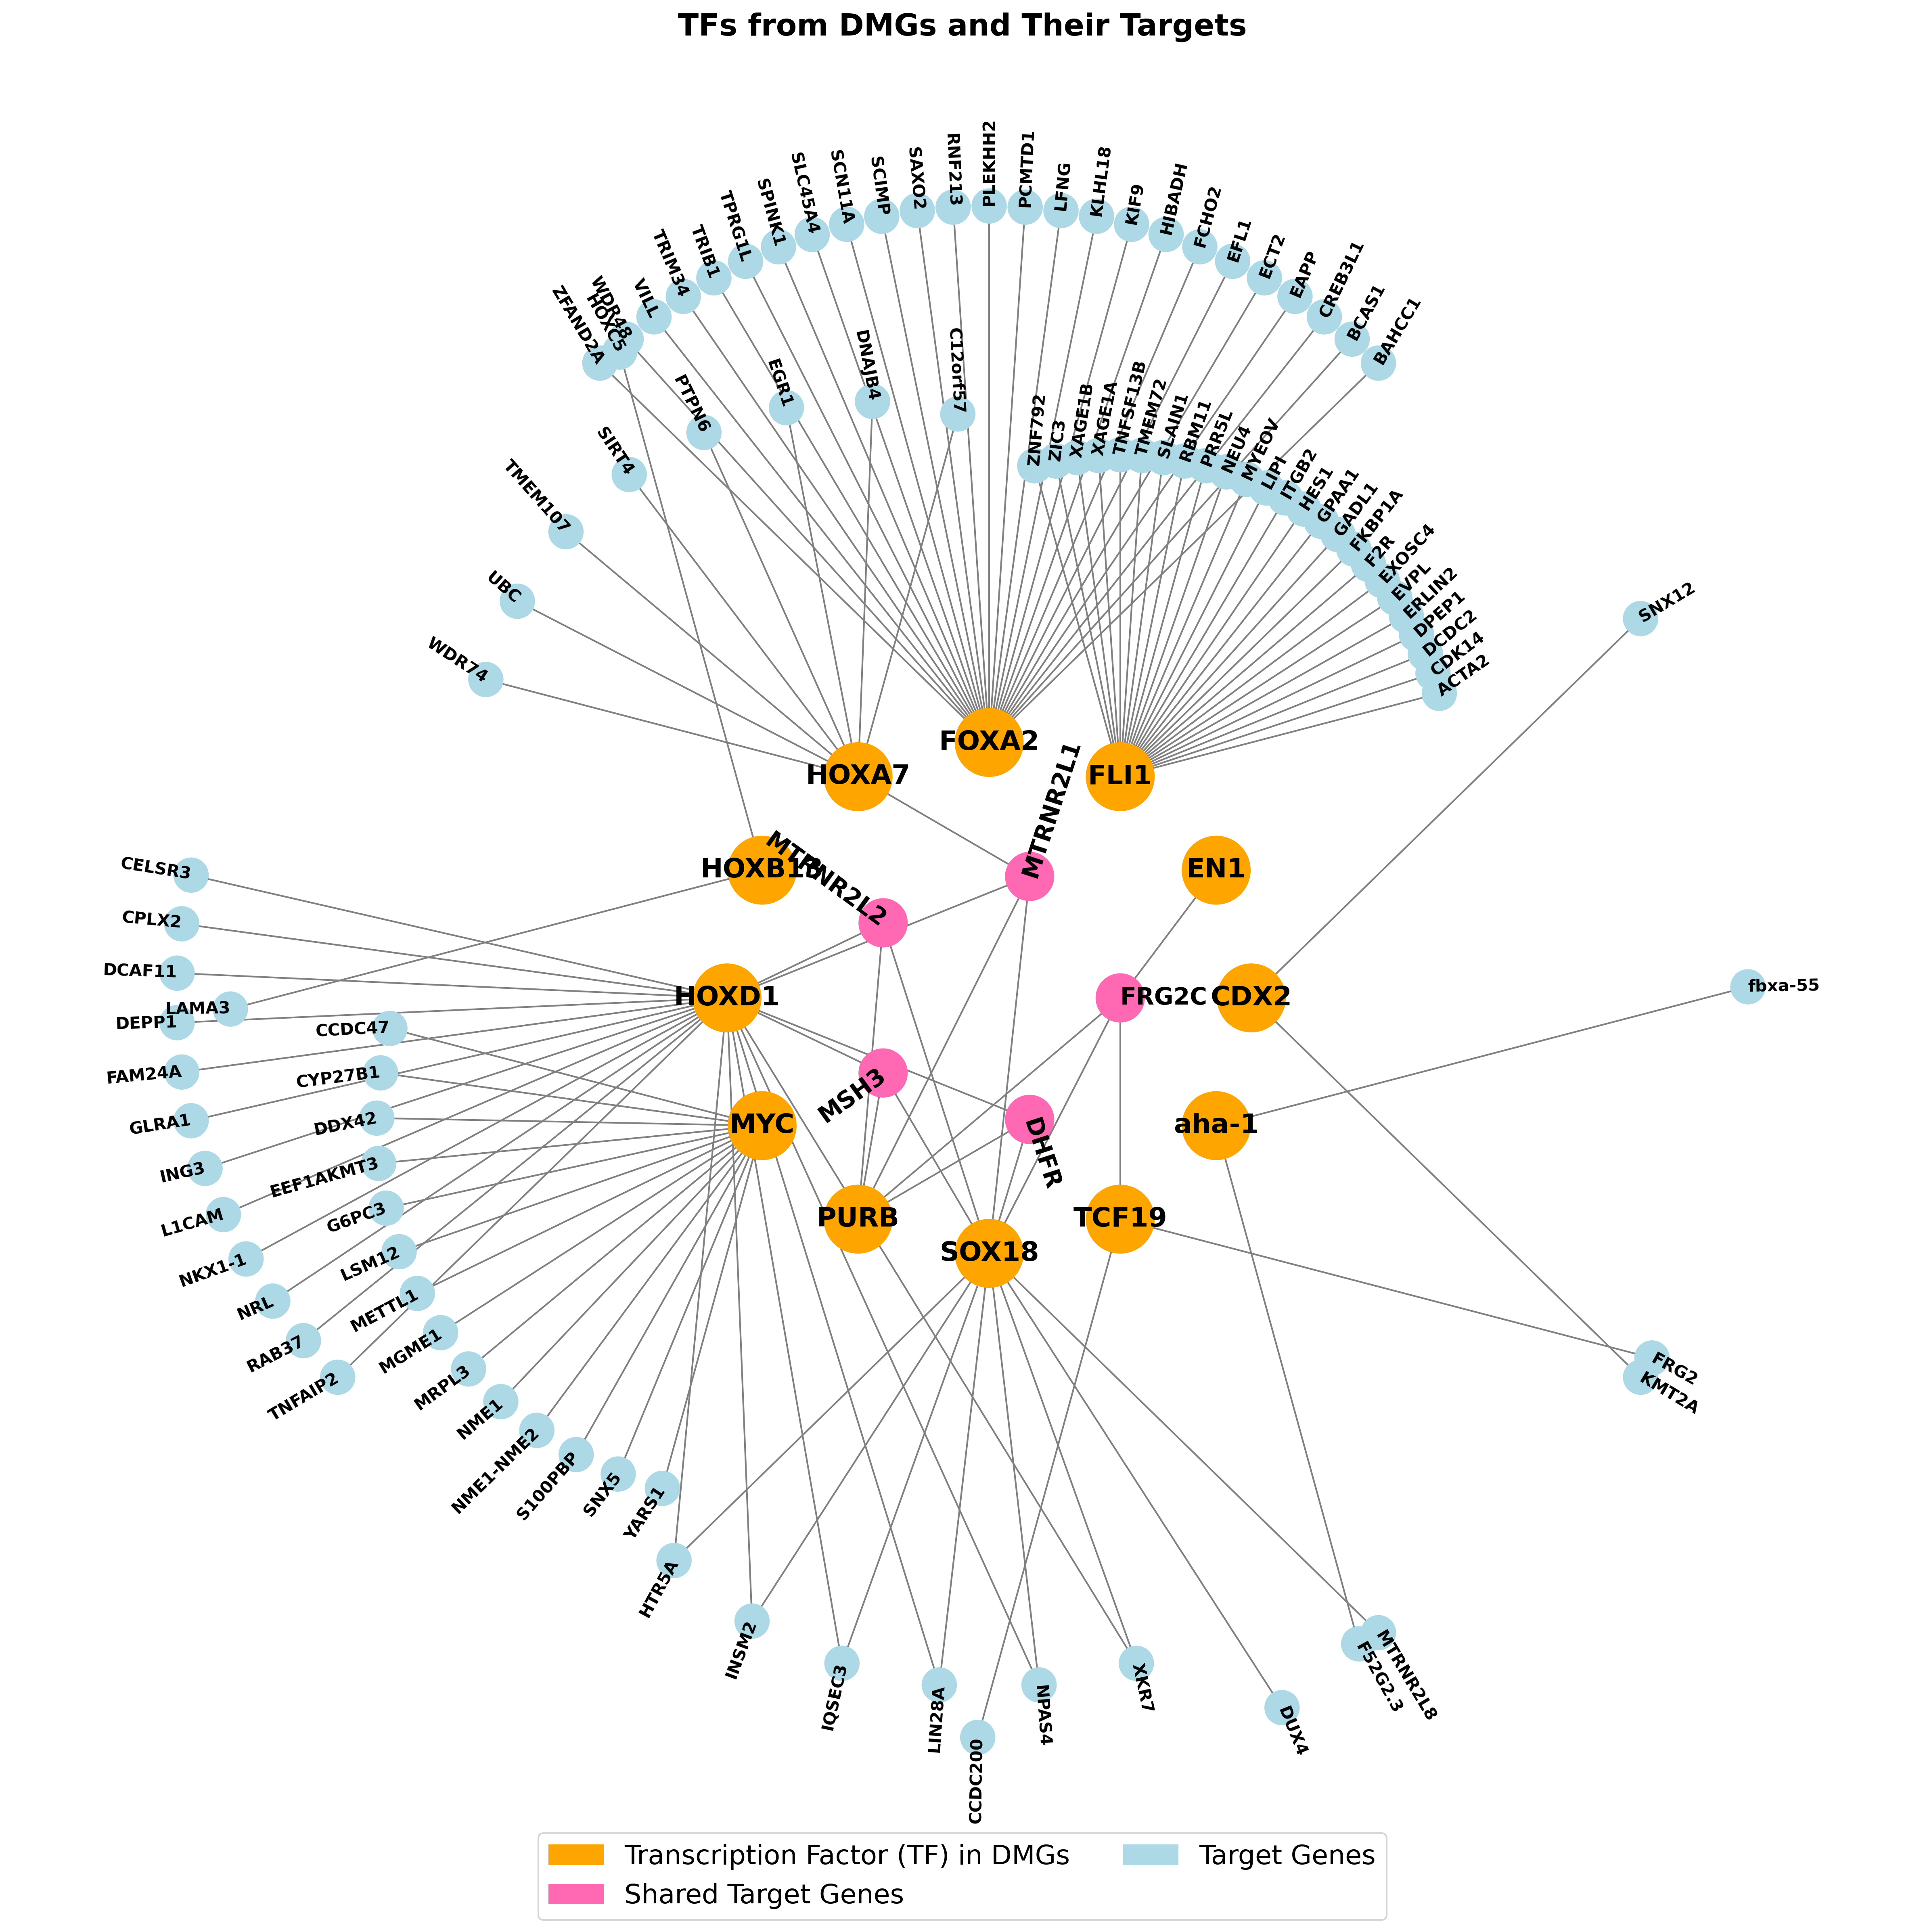

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from collections import defaultdict
import matplotlib.patches as mpatches
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.transparent'] = True
matplotlib.rcParams['path.simplify'] = False  # keep exact vectors

# ── Setup ──
input_dir = "chip_atlas_data"
output_dir = "network_plots_figure4"
os.makedirs(output_dir, exist_ok=True)

max_targets = 25
min_strength = 700

# ── Load TF-target files ──
tf_files = glob.glob(f"{input_dir}/*.tsv")
edges = []
all_tfs = []

for filepath in tf_files:
    tf_name = os.path.basename(filepath).split(".")[0]
    df = pd.read_csv(filepath, sep="\t")

    avg_col = [col for col in df.columns if f"{tf_name}|Average" in col]
    if not avg_col:
        continue
    avg_col = avg_col[0]

    df = df[df[avg_col] >= min_strength].sort_values(avg_col, ascending=False).head(max_targets)
    if df.empty:
        continue

    for _, row in df.iterrows():
        edges.append((tf_name, row["Target_genes"]))
    all_tfs.append(tf_name)

if not edges or not all_tfs:
    raise ValueError("No valid TF-target pairs found.")

# ── Build graph ──
G = nx.DiGraph()
for tf, tgt in edges:
    G.add_edge(tf, tgt)

# ── Count target sharedness ──
target_counts = defaultdict(int)
for _, tgt in edges:
    target_counts[tgt] += 1

# ── Load 74 genes ──
genes_df = pd.read_csv("../../mCG_genenames_coords_withlifted.csv", sep=",")
# Then rename if needed
genes_df.columns = ["gene", "chr", "start", "end", "genename"]

genes_of_interest = set(genes_df["gene"].astype(str).unique())

# ── Layout ──
def radial_fan_layout_with_center(G, top_tfs, target_counts):
    pos = {}
    center_targets = [t for t, c in target_counts.items() if c >= 3]
    placed_targets = set(center_targets)

    # Center shared targets
    for i, tgt in enumerate(center_targets):
        angle = 2 * np.pi * i / len(center_targets)
        x = 0.5 * np.cos(angle)
        y = 0.5 * np.sin(angle)
        pos[tgt] = (x, y)

    # TF fans
    angle_step = 2 * np.pi / len(top_tfs)
    for i, tf in enumerate(top_tfs):
        tf_angle = i * angle_step
        tf_x, tf_y = np.cos(tf_angle), np.sin(tf_angle)
        pos[tf] = (tf_x, tf_y)

        targets = [t for t in G.neighbors(tf) if t not in placed_targets]
        targets.sort(key=lambda g: (-target_counts[g], g))
        spread = np.pi / 2
        offset = -spread / 2

        for j, target in enumerate(targets):
            angle_offset = offset + j * (spread / max(len(targets) - 1, 1))
            angle = tf_angle + angle_offset
            radius = 1.3 + 0.4 * (3 - min(target_counts[target], 3))

            # tweak specific TF radii if needed
            if tf == "FLI1":
                radius *= 0.6
            if tf == "HOXA7":
                radius *= 0.7
            if tf == "MYC":
                radius *= 0.7

            tx = tf_x + radius * np.cos(angle)
            ty = tf_y + radius * np.sin(angle)
            pos[target] = (tx, ty)

    return pos

pos = radial_fan_layout_with_center(G, all_tfs, target_counts)

# ── Node styles ──
node_colors = []
node_sizes = []
font_sizes = {}

for node in G.nodes:
    if node in all_tfs:  # TFs
        node_colors.append("orange")
        node_sizes.append(1600)       # bigger
        font_sizes[node] = 16
    elif target_counts[node] >= 3:  # Shared targets
        if node in genes_of_interest:
            node_colors.append("red")  # overlap + shared
            node_sizes.append(900)
            font_sizes[node] = 14
        else:
            node_colors.append("hotpink")
            node_sizes.append(800)
            font_sizes[node] = 14
    else:  # Regular targets
        if node in genes_of_interest:
            node_colors.append("green")  # overlap unique
            node_sizes.append(600)
            font_sizes[node] = 12
        else:
            node_colors.append("lightblue")
            node_sizes.append(400)
            font_sizes[node] = 10

# ── Draw ──
plt.figure(figsize=(16, 16))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=False)

# Draw labels with per-node font size
for node, (x, y) in pos.items():
    if node in all_tfs:
        ha = 'center'
        angle = 0
    else:
        angle = np.degrees(np.arctan2(y, x))
        if x < 0:
            angle += 180
            ha = 'right'
        else:
            ha = 'left'
    plt.text(
        x, y, node,
        fontsize=font_sizes.get(node, 10),
        fontweight='bold',
        ha=ha, va='center',
        rotation=angle,
        rotation_mode='anchor'
    )

# ── Legend ──
legend_handles = [
    mpatches.Patch(color='orange', label='Transcription Factor (TF) in DMGs'),
    mpatches.Patch(color='hotpink', label='Shared Target Genes'),
    mpatches.Patch(color='lightblue', label='Target Genes'),
    #mpatches.Patch(color='green', label='Overlap with 74 Genes'),
    #mpatches.Patch(color='red', label='Shared Target (≥3 TFs) + in 74 Genes')
]
plt.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.019),
           ncol=2, fontsize=16)

plt.title("TFs from DMGs and Their Targets", fontsize=18, weight='bold')
plt.axis('off')
plt.tight_layout()
#plt.savefig(f"{output_dir}/TFnetweork_fig4.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.savefig(f"{output_dir}/panelA_fig4.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [22]:
pip install gseapy


Note: you may need to restart the kernel to use updated packages.


In [25]:
import gseapy as gp
import pandas as pd
import os

# Output folder
os.makedirs("TF_enrichment", exist_ok=True)

# Shared targets = pink nodes (count > 1)
shared_genes = [g for g, count in shared_counts.items() if count > 1]

# ✅ Run enrichment on shared genes (the pink ones)
if shared_genes:
    print("Running enrichment for shared targets...")
    enr = gp.enrichr(
        gene_list=shared_genes,
        gene_sets=[
            "GO_Biological_Process_2021",
            "GO_Molecular_Function_2021",
            "GO_Cellular_Component_2021",
            "KEGG_2021_Human"
        ],
        organism="Human",
        outdir="TF_enrichment/shared_targets",
        cutoff=0.5
    )
    enr.results.to_csv("TF_enrichment/shared_targets/enrichment_results.csv", index=False)

# ✅ Run enrichment for each TF’s unique target genes
for tf in [n for n in G.nodes if G.nodes[n]["type"] == "TF"]:
    targets = [
        G.nodes[n]["gene"]
        for n in G.successors(tf)
        if G.nodes[n]["type"] == "target"
        and shared_counts.get(G.nodes[n]["gene"], 0) == 1  # only unique
    ]
    if not targets:
        continue
    print(f"Running enrichment for TF: {tf}")
    outdir = f"TF_enrichment/{tf}"
    os.makedirs(outdir, exist_ok=True)
    enr = gp.enrichr(
        gene_list=targets,
        gene_sets=[
            "GO_Biological_Process_2021",
            "GO_Molecular_Function_2021",
            "GO_Cellular_Component_2021",
            "KEGG_2021_Human"
        ],
        organism="Human",
        outdir=outdir,
        cutoff=0.5,
        no_plot=True
    )
    enr.results.to_csv(f"{outdir}/enrichment_results.csv", index=False)


Running enrichment for shared targets...
Running enrichment for TF: CDX2
Running enrichment for TF: FLI1
Running enrichment for TF: FOXA2
Running enrichment for TF: HOXA7
Running enrichment for TF: HOXB13
Running enrichment for TF: HOXD1
Running enrichment for TF: MYC
Running enrichment for TF: SOX18
Running enrichment for TF: TCF19
Running enrichment for TF: aha-1


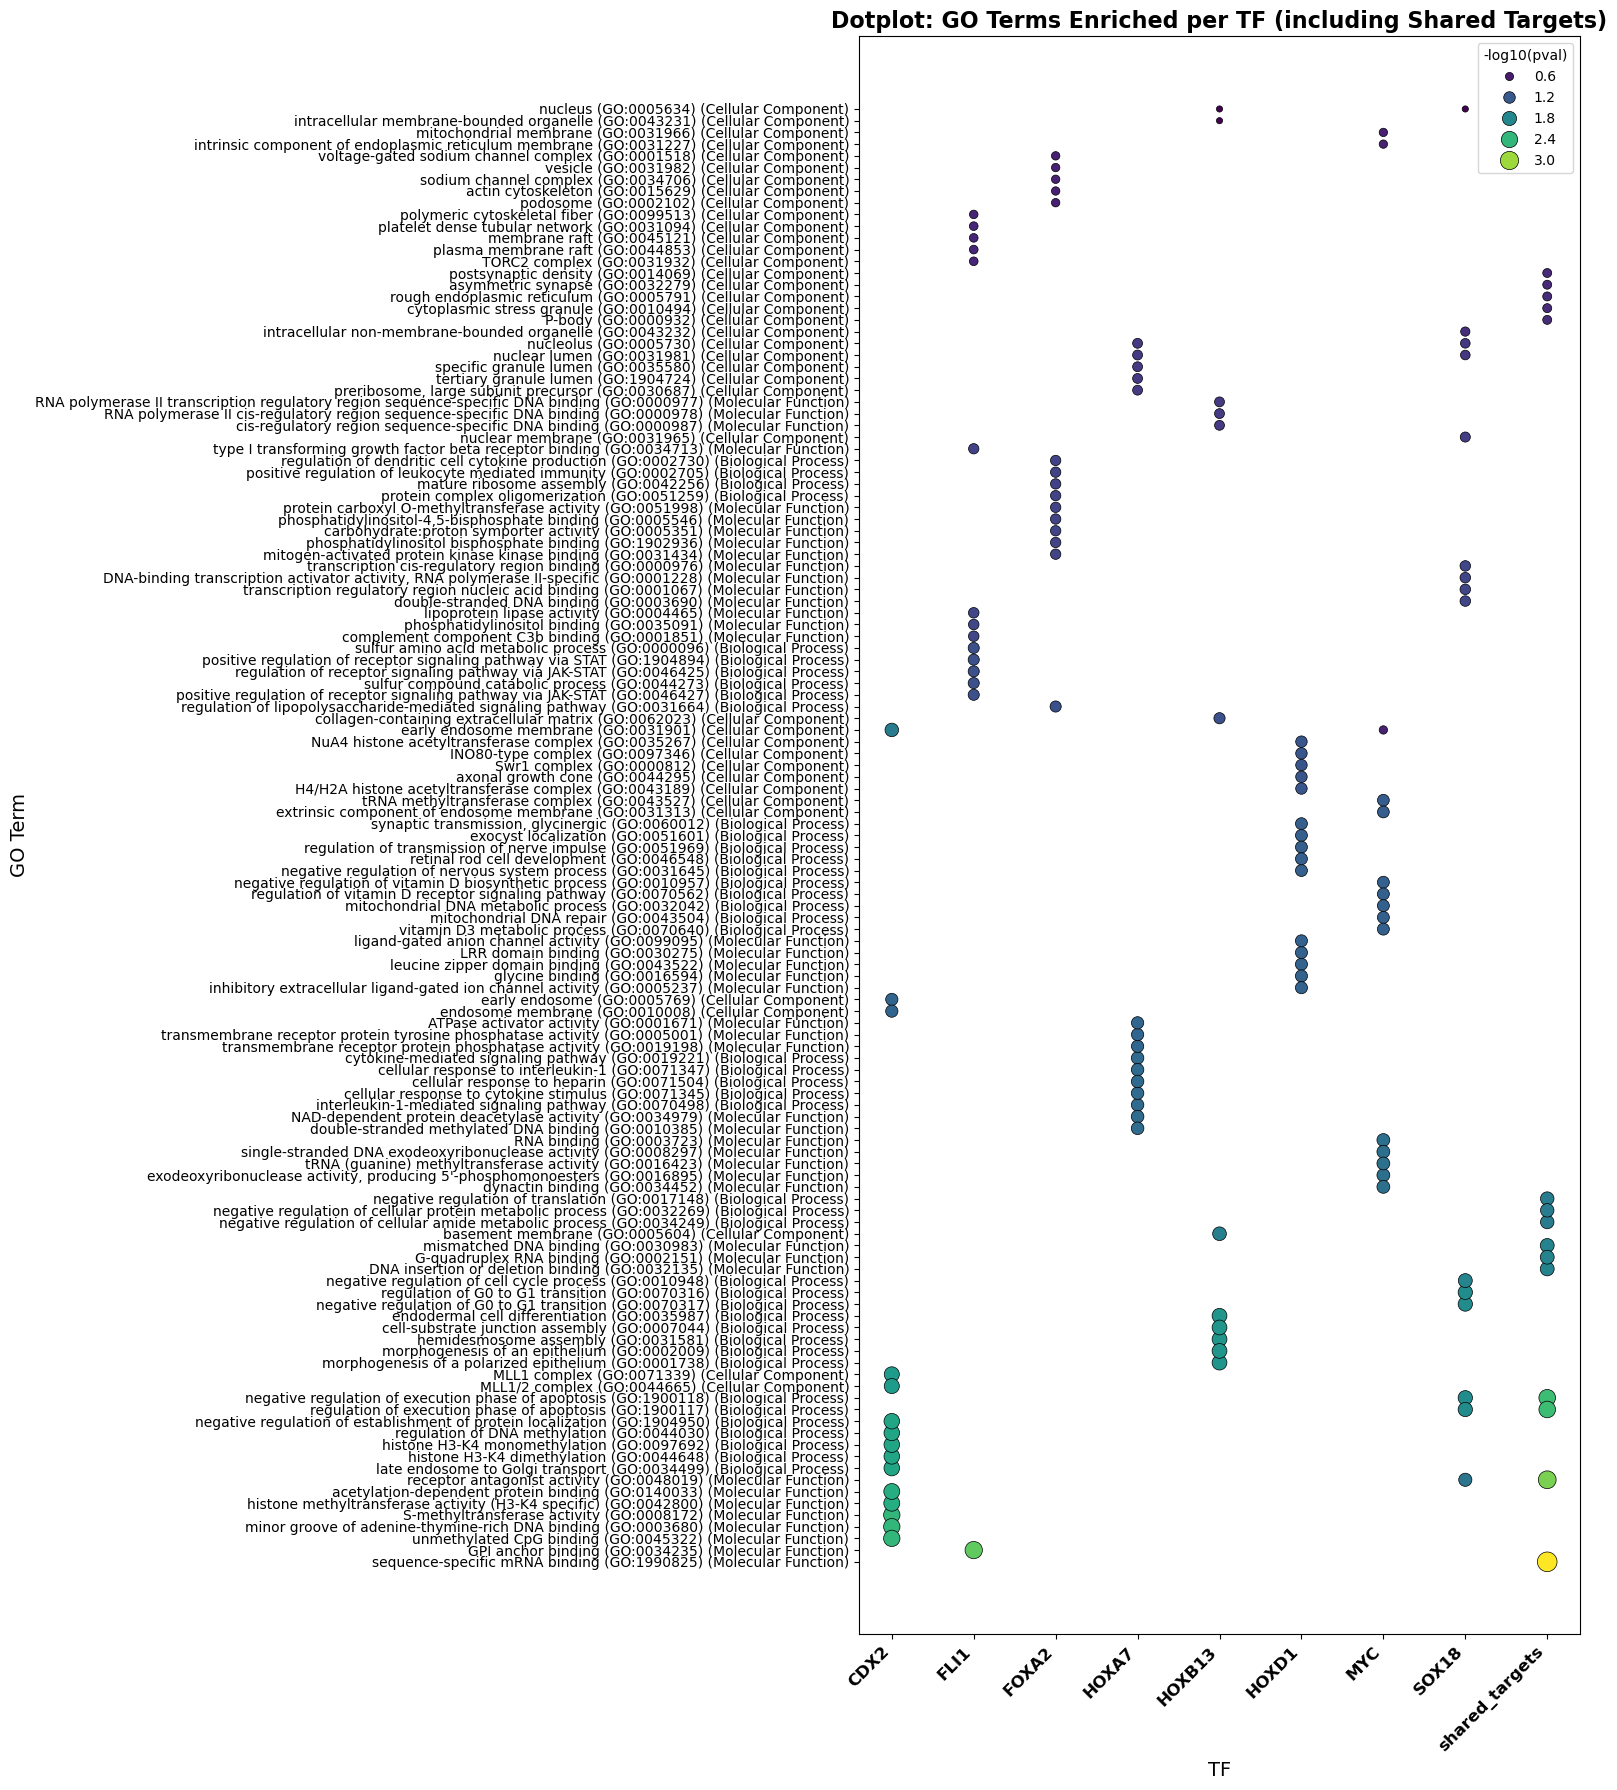

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

top_n = 5
gene_sets = {
    "GO_Biological_Process_2021": "Biological Process",
    "GO_Cellular_Component_2021": "Cellular Component",
    "GO_Molecular_Function_2021": "Molecular Function"
}

all_data = []

# Include all TF folders + shared_targets
for filepath in glob.glob("TF_enrichment/*/enrichment_results.csv"):
    tf = os.path.basename(os.path.dirname(filepath))
    df = pd.read_csv(filepath)
    df["Adjusted P-value"] = pd.to_numeric(df["Adjusted P-value"], errors='coerce')

    for gs_code, gs_label in gene_sets.items():
        sub = df[df["Gene_set"] == gs_code].nsmallest(top_n, "Adjusted P-value")
        for _, row in sub.iterrows():
            all_data.append({
                "TF": tf,
                "GO_term": f"{row['Term']} ({gs_label})",
                "Gene Count": int(row["Overlap"].split("/")[0]),
                "-log10(pval)": -np.log10(row["Adjusted P-value"] + 1e-10),
                "Adjusted P-value": row["Adjusted P-value"],
                "Category": gs_label
            })

# Convert to DataFrame
df_all = pd.DataFrame(all_data)

# Save to CSV for use in R
df_all.to_csv("TF_enrichment/combined_go_results.csv", index=False)

# Build plot dataframe
plot_df = pd.DataFrame(all_data)
plot_df["GO_term"] = pd.Categorical(
    plot_df["GO_term"],
    categories=plot_df.groupby("GO_term")["-log10(pval)"].mean().sort_values().index,
    ordered=True
)

# Plot
plt.figure(figsize=(16, 18))
sns.scatterplot(
    data=plot_df,
    x="TF",
    y="GO_term",
    size="-log10(pval)",
    hue="-log10(pval)",
    palette="viridis",
    sizes=(20, 200),
    legend="brief",
    edgecolor="black",
)

plt.title("Dotplot: GO Terms Enriched per TF (including Shared Targets)", fontsize=16, weight='bold')
plt.xlabel("TF", fontsize=14)
plt.ylabel("GO Term", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("TF_enrichment/tf_and_shared_go_combined_dotplot.png", dpi=300)
plt.show()


In [5]:
import pandas as pd
import numpy as np
import glob
import os

# Setup
top_n = 5
qval_thresh = 0.05

gene_sets = {
    "GO_Biological_Process_2021": "Biological Process",
    "GO_Cellular_Component_2021": "Cellular Component",
    "GO_Molecular_Function_2021": "Molecular Function"
}

all_data = []

# Aggregate enriched GO terms
for filepath in glob.glob("TF_enrichment/*/enrichment_results.csv"):
    tf = os.path.basename(os.path.dirname(filepath))
    df = pd.read_csv(filepath)
    df["Adjusted P-value"] = pd.to_numeric(df["Adjusted P-value"], errors='coerce')
    df["p-value"] = pd.to_numeric(df.get("P-value", df["Adjusted P-value"]), errors='coerce')

    for gs_code, gs_label in gene_sets.items():
        subset = df[(df["Gene_set"] == gs_code) & (df["Adjusted P-value"] < qval_thresh)]
        subset = subset.nsmallest(top_n, "Adjusted P-value")

        for _, row in subset.iterrows():
            overlap = row["Overlap"]
            count = int(overlap.split("/")[0])
            gene_ratio = count / 100  # Estimate (100 = assumed input gene count)
            bg_ratio = 10 / 2000      # Estimate (arbitrary background size)
            odds_ratio = gene_ratio / bg_ratio

            all_data.append({
                "TF": tf,
                "Description": row["Term"],
                "Gene Count": count,
                "GeneRatio": overlap,
                "BgRatio": "10/2000",  # Dummy bg
                "pvalue": row["p-value"],
                "p.adjust": row["Adjusted P-value"],
                "Ontology": gs_label,
                "OddsRatio": odds_ratio
            })

# Export to file
df_out = pd.DataFrame(all_data)
df_out.to_csv("TF_enrichment/GO_combined_enrich_like_clusterProfiler.csv", index=False)


In [6]:
import pandas as pd
import numpy as np
import glob
import os

# Parameters
top_n = 5
qval_thresh = 0.05

all_data = []

# Loop through TF-specific KEGG enrichment results
for filepath in glob.glob("TF_enrichment/*/enrichment_results.csv"):
    tf = os.path.basename(os.path.dirname(filepath))
    df = pd.read_csv(filepath)
    df["Adjusted P-value"] = pd.to_numeric(df["Adjusted P-value"], errors='coerce')
    df["p-value"] = pd.to_numeric(df.get("P-value", df["Adjusted P-value"]), errors='coerce')

    # Filter for KEGG pathway results
    df_kegg = df[(df["Gene_set"] == "KEGG_2021_Human") & (df["Adjusted P-value"] < qval_thresh)]
    df_kegg = df_kegg.nsmallest(top_n, "Adjusted P-value")

    for _, row in df_kegg.iterrows():
        overlap = row["Overlap"]
        count = int(overlap.split("/")[0])
        gene_ratio = count / 100   # estimated input size
        bg_ratio = 10 / 2000       # estimated background
        odds_ratio = gene_ratio / bg_ratio

        all_data.append({
            "TF": tf,
            "Description": row["Term"],
            "Gene Count": count,
            "GeneRatio": overlap,
            "BgRatio": "10/2000",
            "pvalue": row["p-value"],
            "p.adjust": row["Adjusted P-value"],
            "Ontology": "KEGG",
            "OddsRatio": odds_ratio
        })

# Save for R plotting
df_kegg_out = pd.DataFrame(all_data)
df_kegg_out.to_csv("TF_enrichment/KEGG_combined_enrich_like_clusterProfiler.csv", index=False)


In [7]:
import pandas as pd
import numpy as np
import glob
import os

# Parameters
top_n = 5
qval_thresh = 0.05

all_data = []

# Loop through TF-specific KEGG enrichment results
for filepath in glob.glob("TF_enrichment/*/enrichment_results.csv"):
    tf = os.path.basename(os.path.dirname(filepath))
    df = pd.read_csv(filepath)
    df["Adjusted P-value"] = pd.to_numeric(df["Adjusted P-value"], errors='coerce')
    df["p-value"] = pd.to_numeric(df.get("P-value", df["Adjusted P-value"]), errors='coerce')

    # Filter for KEGG pathway results
    df_kegg = df[(df["Gene_set"] == "KEGG_2021_Human") & (df["Adjusted P-value"] < qval_thresh)]
    df_kegg = df_kegg.nsmallest(top_n, "Adjusted P-value")

    for _, row in df_kegg.iterrows():
        overlap = row["Overlap"]
        count = int(overlap.split("/")[0])
        gene_ratio = count / 100   # estimated input size
        bg_ratio = 10 / 2000       # estimated background
        odds_ratio = gene_ratio / bg_ratio

        all_data.append({
            "TF": tf,
            "Description": row["Term"],
            "Gene Count": count,
            "GeneRatio": overlap,
            "BgRatio": "10/2000",
            "pvalue": row["p-value"],
            "p.adjust": row["Adjusted P-value"],
            "Ontology": "KEGG",
            "OddsRatio": odds_ratio
        })

# Save for R plotting
df_kegg_out = pd.DataFrame(all_data)
df_kegg_out.to_csv("TF_enrichment/KEGG_combined_enrich_like_clusterProfiler.csv", index=False)


In [ ]:
# plot heatmap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_df, cmap="YlGnBu", linewidths=0.5, annot=True)
plt.title("Top GO Terms Across TFs (-log10 adj p-value)")
plt.xlabel("TF")
plt.ylabel("GO Term")
plt.tight_layout()
plt.savefig("TF_enrichment/GO_heatmap.png", dpi=300)
plt.show()
